**HyperTS支持解决单变量时序预测, 多变量时序预测任务。**

**在本NoteBook中, 我们利用HyperTS做一个时序预测任务。**

### Step 1: 首先，我们导入示例数据集**network traffic**, 并做EDA分析数据。

In [1]:
from hyperts.datasets import load_network_traffic

In [2]:
df = load_network_traffic()

In [3]:
df.head()

,TimeStamp,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,HourSin,WeekCos,CBWD
0,2021-03-01 00:00:00,0.7534,3.375,10.195,1.4490,19174.977,286443.880,0.000000,1.0,NW
1,2021-03-01 01:00:00,0.3376,2.414,3.920,0.4065,7529.263,178930.450,0.258819,1.0,NW
2,2021-03-01 02:00:00,0.2032,1.654,3.318,0.2142,3310.539,42296.164,0.500000,1.0,NW
3,2021-03-01 03:00:00,0.2420,1.393,3.148,0.2312,4535.464,26220.232,0.707107,1.0,NW
4,2021-03-01 04:00:00,0.1940,1.429,3.215,0.2157,2732.911,27990.348,0.866025,1.0,NW


由数据我们可知：

- 时间列名称: 'TimeStamp';
- 目标列名称: ['Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6'];
- 协变量列名称: ['HourSin', 'WeekCos', 'CBWD'];
- 时间频率: 'H'.
  
由目标变量的具体数值可知，变量之间是存在量纲差异的。

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TimeStamp  2878 non-null   object 
 1   Var_1      2878 non-null   float64
 2   Var_2      2878 non-null   float64
 3   Var_3      2877 non-null   float64
 4   Var_4      2877 non-null   float64
 5   Var_5      2877 non-null   float64
 6   Var_6      2877 non-null   float64
 7   HourSin    2878 non-null   float64
 8   WeekCos    2878 non-null   float64
 9   CBWD       2878 non-null   object 
dtypes: float64(8), object(2)
memory usage: 225.0+ KB


可以看出, 这个数据是存在缺失值的。TimeStamp的类型是object。

In [5]:
import pandas as pd

time_start = df['TimeStamp'].tolist()[0]
time_end = df['TimeStamp'].tolist()[-1]

complete_time_df = pd.date_range(start=time_start, end=time_end, freq='H')

complete_time_length = len(complete_time_df)
actual_time_length = len(df)

print('time start: {} - time end: {}'.format(time_start, time_end))
print('complete_time_length: {} - actual_time_length: {}'.format(complete_time_length, actual_time_length))

time start: 2021-03-01 00:00:00 - time end: 2021-06-30 23:00:00
complete_time_length: 2928 - actual_time_length: 2878


通过计算可以看出，如果时间序列起始时间是2021-03-01 00:00:00, 结束时间是2021-06-30 23:00:00，以小时(H)为时间粒度，那么自然序列共有2928个时间点，但是实际上数据共有2878个时间点。因此，此数据在收集过程中，可能由于某些因素丢失了某些时间片段的值。

现在，我们从中选择变量Var_3做为目标变量，做一个单变量预测，并分割数据为训练集和测试集。

对于数据集的分割，我们可以使用sklearn.model_selection内置的```train_test_split```的函数，这里hyperts也提供了相应的函数```temporal_train_test_split```供使用。

**任务目标:** 根据历史数据信息来预测未来168个时间点的信息。

In [6]:
from hyperts.toolbox import temporal_train_test_split

df = df.drop(['Var_1', 'Var_2','Var_4','Var_5','Var_6'], axis=1)

train_data, test_data = temporal_train_test_split(df, test_horizon=168)

In [7]:
train_data.head()

,TimeStamp,Var_3,HourSin,WeekCos,CBWD
0,2021-03-01 00:00:00,10.195,0.000000,1.0,NW
1,2021-03-01 01:00:00,3.920,0.258819,1.0,NW
2,2021-03-01 02:00:00,3.318,0.500000,1.0,NW
3,2021-03-01 03:00:00,3.148,0.707107,1.0,NW
4,2021-03-01 04:00:00,3.215,0.866025,1.0,NW


In [8]:
test_data.tail()

,TimeStamp,Var_3,HourSin,WeekCos,CBWD
2873,2021-06-30 18:00:00,10.530,-1.000000,-0.222521,NW
2874,2021-06-30 20:00:00,12.890,-0.866025,-0.222521,NW
2875,2021-06-30 21:00:00,12.920,-0.707107,-0.222521,SE
2876,2021-06-30 22:00:00,9.016,-0.500000,-0.222521,cv
2877,2021-06-30 23:00:00,9.970,-0.258819,-0.222521,NE


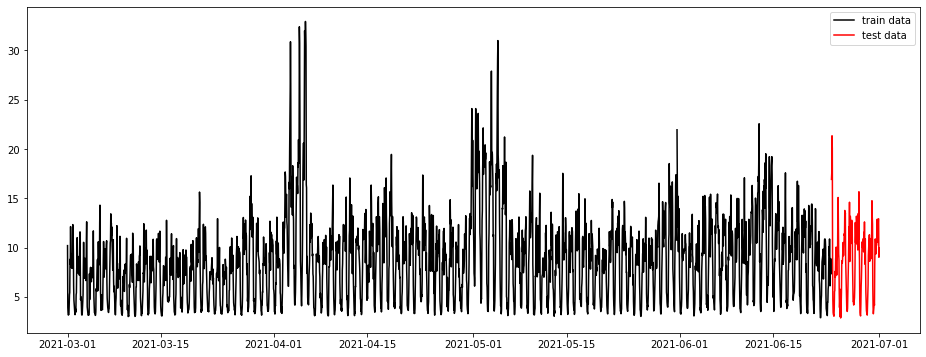

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(train_data['TimeStamp']), train_data['Var_3'], c='k', label='train data')
plt.plot(pd.to_datetime(test_data['TimeStamp']), test_data['Var_3'], c='r', label='test data')
plt.legend()
plt.show()

### Step 2: 创建实验并搜索模型。

- 为了方便且避免定义参数书写错误, 我们可以使用```hyperts.utils```中的```consts```来获取符合条件的变量名。
- 为了搜索到更好的模型，我们通过调整参数```max_trials```来增加搜索的次数。
  同时避免陷入长时间的无效搜索，我们增加早停策略，及```early_stopping_rounds```限制不提升轮数和```early_stopping_time_limit```运行总时间。
- HyperTS默认是进化搜索，我们可以通过调整参数```searcher```将其更改为蒙特卡洛树搜索。

In [10]:
from hyperts.utils import consts
from hyperts import make_experiment

In [11]:
experiment = make_experiment(train_data=train_data.copy(),
                task=consts.Task_UNIVARIATE_FORECAST,
                mode=consts.Mode_STATS,
                timestamp='TimeStamp',
                covariables=['HourSin', 'WeekCos', 'CBWD'],
                max_trials=5,
                early_stopping_rounds=10,
                early_stopping_time_limit=3600,
                reward_metric='mae',
                searcher='mcts')

model = experiment.run()

### Step 3: 获得模型的参数。

In [12]:
model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('data_preprocessing',
                 TSFDataPreprocessStep(covariate_cols=['HourSin', 'WeekCos',
                                                       'CBWD'],
                                       covariate_data_clean_args={'correct_object_dtype': False,
                                                                  'drop_columns': None,
                                                                  'drop_constant_columns': True,
                                                                  'drop_duplicated_columns': False,
                                                                  'drop_idness_columns': True,
                                                                  'drop_label_nan_rows': True,
                                                                  'int_convert_to': 'float',
                                                                  'nan_chars': None,
                                 

### Step 4: 对于测试数据(未知数据)进行预测推理。

In [13]:
X_test, y_test = model.split_X_y(test_data.copy())

In [14]:
X_test.head()

,TimeStamp,HourSin,WeekCos,CBWD
2710,2021-06-23 19:00:00,-0.965926,-0.222521,NW
2711,2021-06-23 20:00:00,-0.866025,-0.222521,cv
2712,2021-06-23 21:00:00,-0.707107,-0.222521,NW
2713,2021-06-23 22:00:00,-0.500000,-0.222521,NW
2714,2021-06-23 23:00:00,-0.258819,-0.222521,NW


In [15]:
forecast = model.predict(X_test)
forecast.head()

,TimeStamp,Var_3
2710,2021-06-23 19:00:00,10.518559
2711,2021-06-23 20:00:00,10.883351
2712,2021-06-23 21:00:00,10.618050
2713,2021-06-23 22:00:00,9.270074
2714,2021-06-23 23:00:00,7.144689


HyperTS的```predict```将输出一个DataFrame, 其包含X_test中所有时间的目标变量预测值。

### Step 5: 在评估过程，我们可以采用HyperTS的```evaluate```函数，其对各种任务默认内置了一些评估指标。

In [16]:
results = model.evaluate(y_true=y_test, y_pred=forecast)
results.head()

,Metirc,Score
0,mae,1.3301
1,mse,4.0493
2,rmse,2.0123
3,mape,0.1549
4,smape,0.1526


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

results = model.evaluate(y_true=y_test, y_pred=forecast, metrics=[mean_absolute_error, mean_squared_error, 'mape'])
results.head()

,Metirc,Score
0,mean_absolute_error,1.3301
1,mean_squared_error,4.0493
2,mape,0.1549


### Step 6: 可视化预测曲线。

HyperTS支持两种方式绘制预测曲线，一种是可互动的(需要安装plotly)，一种是不可互动的(需要安装matplotlib)，默认是互动的，如果想绘制非互动的，可设置参数```interactive=False```。

In [18]:
model.plot(forecast=forecast, actual=test_data)

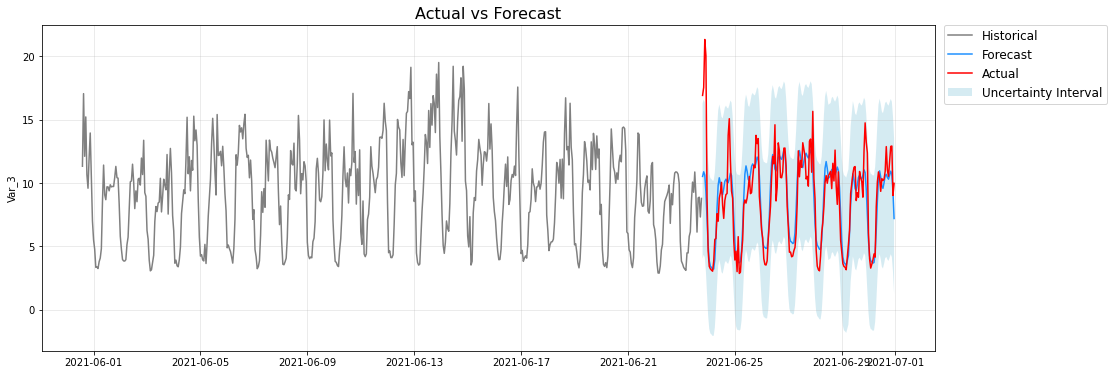

In [19]:
model.plot(forecast=forecast, actual=test_data, interactive=False)